Today's project is to learn how to conduct a rolling regression in R, and use it to evaluate time series data at different forecasts. As always with this blog, I attempt to explain R concepts in plain english, rather than in the sometimes confusing language found in the official documentations. The key takeaways are:

 - zoo does not play well with dplyr. Make sure to transform dplyr objects backto data frames before creating zoo formats.

 - "Align = right" means if you have a rolling regression from March 1 1983 to March 1 1984, the final value in the output lines up with March 1 1984.  "Align = left" would output the initial value at time March 1 1983.

In [44]:
library(zoo, quietly=TRUE, warn=FALSE)
library(dplyr, quietly=TRUE, warn=FALSE)
library(stargazer, quietly=TRUE, warn=FALSE)
library(reshape2, quietly=TRUE, warn=FALSE)
library(ggplot2, quietly=TRUE, warn=FALSE)

I prefer to use simulated data to see precisely what is going on

In [45]:
#generate some data
x <- rnorm(1000,mean=5,sd=1) 

#generate a number of dates, starting from my Birthday!
date<-seq(as.Date("1983/03/05"),by="day",length.out=1000)

#Set up a transform variable to create a structural break
transform <- c(rep(4,500),rep(6,500))

#create y variable with structural break and some noise
y <- x * transform + rnorm(1000) 

A quick check to make sure everything looks dandy, using dplyr for typical manipulation:

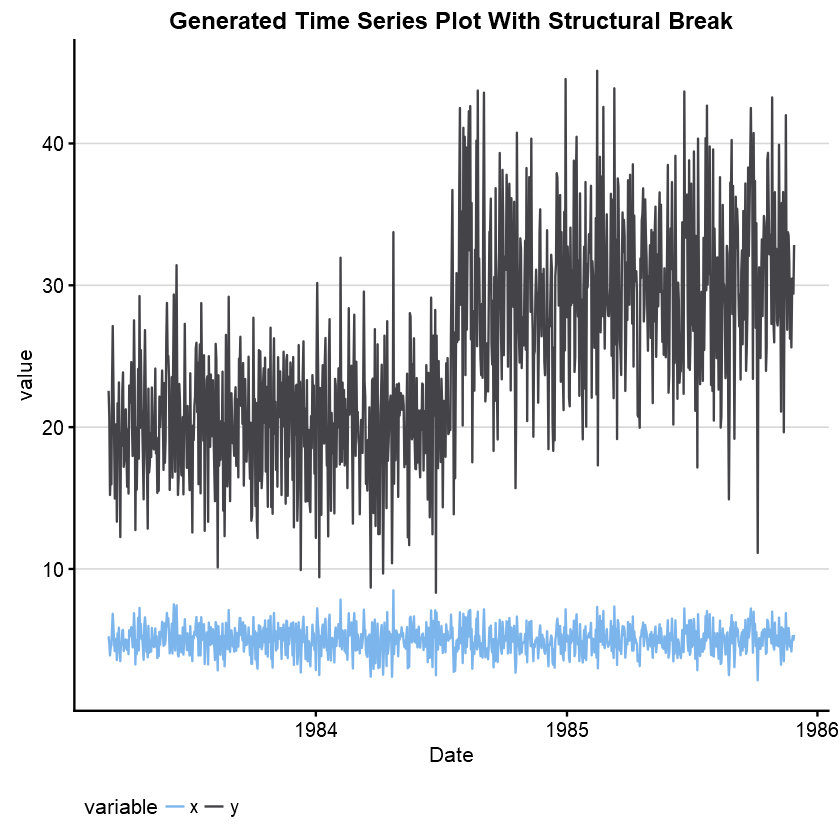

In [46]:
library(ggthemes) 

#First step, put df into a dplyr data table
df <- tbl_df(data.frame(Date=date,x=x,y=y)) %>% melt(id.vars = 'Date')

#Ensure that our transformation worked
ggplot(df, aes(x = Date, y=value, color=variable)) + 
    geom_line() + 
    ggtitle("Generated Time Series Plot With Structural Break") +
    theme_hc()+ 
    scale_colour_hc()


Looks like we have our structural break that will show up when we run the rolling regression.

In [47]:
df.zoo<-read.zoo(df)
head(df.zoo)

Warning message in zoo(rval3, ix):
"some methods for "zoo" objects do not work if the index entries in 'order.by' are not unique"Warning message in zoo(rval, index(x)[i]):
"some methods for "zoo" objects do not work if the index entries in 'order.by' are not unique"

           variable value    
1983-03-05 x         5.260535
1983-03-05 y        22.563550
1983-03-06 x         4.730987
1983-03-06 y        20.692846
1983-03-07 x         3.902624
1983-03-07 y        15.216811

As I said, zoo does not play well with dplyr

In [48]:
df.zoo<-read.zoo(df %>% dcast(Date ~ variable))
head(df.zoo)

                  x        y
1983-03-05 5.260535 22.56355
1983-03-06 4.730987 20.69285
1983-03-07 3.902624 15.21681
1983-03-08 4.470181 17.09049
1983-03-09 4.616776 15.96549
1983-03-10 5.862327 23.09719

That seemed to work.  We had to do convert our flattened array back to wide shape.  Just to prove it worked, lets run a rolling average:

                  x        y
1983-03-19 4.840196 19.19004
1983-03-20 4.854489 19.20253
1983-03-21 4.872160 19.24008
1983-03-22 4.924714 19.45685
1983-03-23 4.972585 19.70685
1983-03-24 4.995971 19.85235

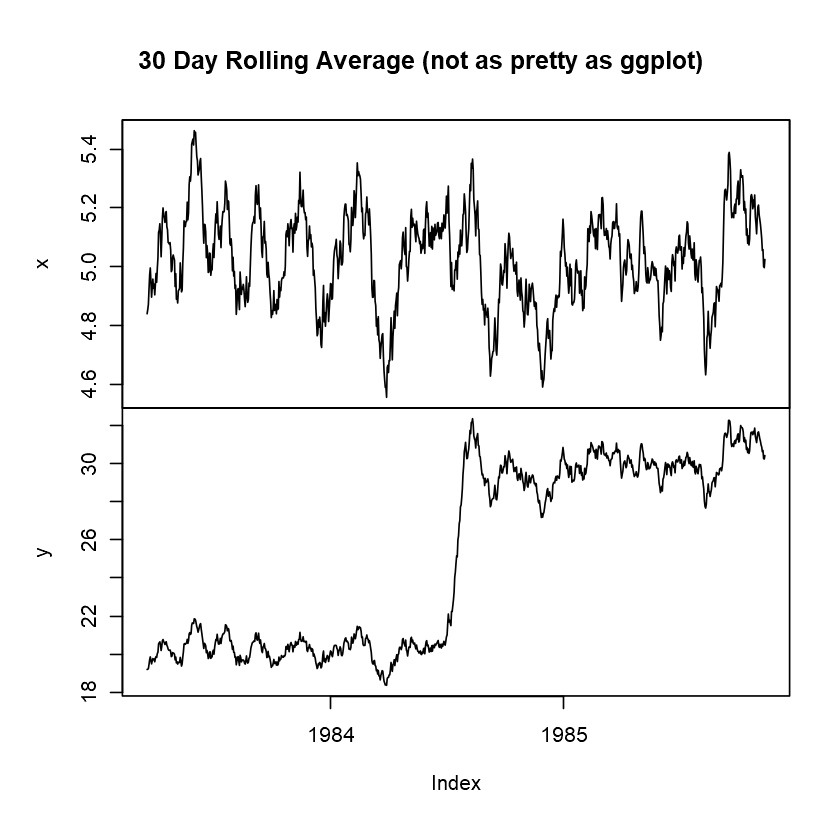

In [52]:
head(rollmean(df.zoo, 30))

plot.zoo(rollmean(df.zoo, 30),main = "30 Day Rolling Average (not as pretty as ggplot)")

Note that "window" is an overlapping concept. This mean that if your window is 28 days and you start on February 28th, the data point in the rolling mean will average values on February 1 - February 28. The second mean cover the data on February 2 to March 1 etc. You also have the option of adding a "by" clause that will add non-overlapping means.

Several points to note about the output.

First: Compare this graph of the rolling mean of Y with the graph above. Notice anything strange? The index is reversed. This is a function of the Date variable and the natural order of a "zoo" object, which starts from the oldest value first.
Second, notice that the output from a zoo object covers all variables in the data frame.

kay, onto rolling regression:

Here are some details on the syntax: for rollapply a general wrapper for any rolling function.

### rollapply(data,width, fun, align, by.column)

 - data = your .zoo data frame

 - width = same as above, the window over which your  rolling function will apply

 - FUN = the function that you are actually applying.  This syntax is quite strange, particularly for a regression.

 - **For a regression, you MUST (a) declare a function that takes arguments (FUN=function(z))**

 - **You must also specify that the regression is run on a data.frame, not on a zoo object!  (This is silly and frustrating if you don't know it.) **

 - You must specify that the data in your regression is the same as passed into the function (data = z)


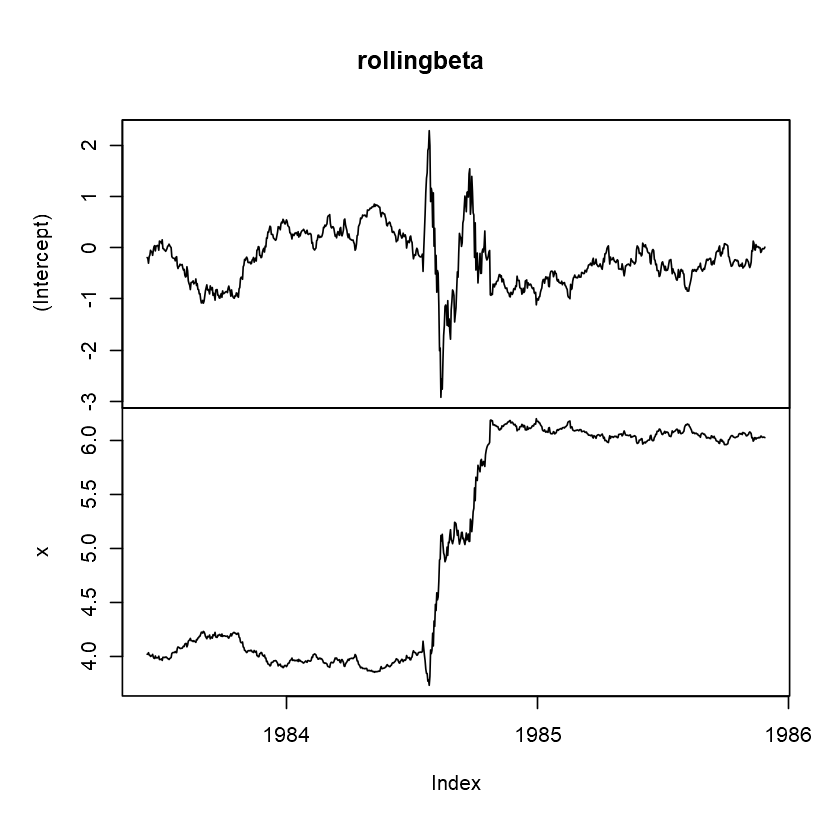

In [50]:
rollingbeta <-rollapply(df.zoo,
                         width=100,
                         FUN=function(z) coef(lm(y~x,data=as.data.frame(z))),
                         align="right",
                         by.column=FALSE)

plot.zoo(rollingbeta)

Finally a few things about the graph.  First, it clearly shows the structural break, part of the motivation for a rolling regression.  Second both variables are there, and more would be if we had more right hand side regressors.  Zoo also spits out the data with a date index to boot.